In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.schedules import CosineDecay
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Custom Modules
from model.vae import Encoder, Decoder, AutoencoderKL, SDPatchGANDiscriminator
from model.unet import UNetModelSmall
from model.text_encoder import TextEncoderWrapper
import input_pipeline
from trainer import VAETrainer, LatentDiffusionTrainer



In [2]:
# Hardware Setup
def setup_hardware():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Restrict TensorFlow to only use the fourth GPU
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

setup_hardware()



1 Physical GPUs, 1 Logical GPUs


In [3]:
ROOT = './dataset'
VOCAB = '/dictionary/id2Word.npy'
WORD2ID = '/dictionary/word2Id.npy'
ID2WORD = '/dictionary/id2Word.npy'
TRAIN = '/dataset/text2ImgData.pkl'
TEST = '/dataset/testData.pkl'



In [4]:
train_path = ROOT+TRAIN
vocab_path = ROOT+VOCAB
word2_id_path = ROOT+WORD2ID
id2_word_path = ROOT+ID2WORD
save_embeding_path = "./seqemb/seq_emb_multi.npy"



In [5]:
# Load Dictionaries (Global as they are small and needed everywhere)
try:
    vocab = np.load(vocab_path)
    print('there are {} vocabularies in total'.format(len(vocab)))
    word2Id_dict = dict(np.load(word2_id_path))
    id2word_dict = dict(np.load(id2_word_path))
except FileNotFoundError:
    print("Warning: Dictionaries not found. Proceeding assuming they might not be needed immediately if re-generating embeddings.")



there are 5429 vocabularies in total


In [6]:
def run_preprocessing():
    """Run text preprocessing using CLIP. This function scopes the TextEncoderWrapper 
    so it can be garbage collected after use."""

    print("\n[Preprocessing] Checking if embeddings need to be generated...")
    # Only run if you need to generate embeddings
    # preprocess_captions_all(train_path, save_embeding_path, max_caption_len=5)
    
    # print("[Preprocessing] Loading Text Encoder for testing...")
    # text_encoder = TextEncoderWrapper()
    
    # sample = ['9', '1', '82', '5', '11', '70', '20', '31', 
    #           '3', '29', '20', '2', '5427', '5427', '5427', '5427', 
    #           '5427', '5427', '5427', '5427']
    # # 注意：id2word_dict 需要是全局變數或傳入
    # sample_emb = text_encoder.id2clip(sample, id2word_dict)
    # print("Sample embedding shape:", sample_emb.shape)
    
    # # Explicitly delete to be safe, though function scope handles it
    # del text_encoder
    # gc.collect()
    # tf.keras.backend.clear_session()
    # print("[Preprocessing] Text Encoder memory released.\n")
    
    print("[Preprocessing] Skipped live encoding test (using pre-computed embeddings).")



In [7]:
def get_vae_models():
    """Load and return VAE (Encoder/Decoder) with weights loaded."""
    decoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/decoder.h5",
                file_hash="6d3c5ba91d5cc2b134da881aaa157b2d2adc648e5625560e3ed199561d0e39d5",
            )

    encoder_weights_fpath = keras.utils.get_file(
        origin="https://huggingface.co/divamgupta/stable-diffusion-tensorflow/resolve/main/encoder_newW.h5",
        file_hash="56a2578423c640746c5e90c0a789b9b11481f47497f817e65b44a1a5538af754",
    )

    print("[VAE] Loading Decoder...")
    decoder = Decoder()
    latent = keras.layers.Input((16,16,4))
    decoder_model = keras.models.Model(latent, decoder(latent))
    decoder_model.load_weights(decoder_weights_fpath)

    print("[VAE] Loading Encoder...")
    encoder = Encoder()
    inp_img = keras.layers.Input((128,128,3))
    encoder_model = keras.models.Model(inp_img, encoder(inp_img))
    encoder_model.load_weights(encoder_weights_fpath)
    
    # Return inner models directly or wrapped ones depending on use
    # trainer.py uses 'vae' which wraps inner encoder/decoder
    # but LatentDiffusionTrainer uses vae.encoder / vae.decoder
    
    vae = AutoencoderKL(encoder, decoder, latent_channels=4, scaling_factor=0.18215)
    return vae, encoder_model, decoder_model



In [8]:
def run_vae_training(vae, BATCH_SIZE=16):
    """Run VAE Training. Separation allows keeping Discriminator/LPIPS ONLY in this scope."""
    print("\n[VAE Training] Initializing Discriminator and Trainer...")
    
    discriminator = SDPatchGANDiscriminator(
        input_channels=3,
        base_filters=64,
        n_layers=3
    )
    
    h_disc_start = 0 # Example config
    trainer = VAETrainer(
        vae, 
        discriminator,
        disc_start=h_disc_start,
        kl_weight=1e-6,
        perc_weight=0.1,
        disc_weight=0.05
    ) # This loads VGG19 inside!

    base_lr = 4.5e-6
    lr = base_lr * BATCH_SIZE
    vae_opt = keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.9)
    disc_opt = keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.9)

    trainer.compile(vae_optimizer=vae_opt, disc_optimizer=disc_opt)
    
    # ... Training loop would go here ...
    print("[VAE Training] Done (Placeholder). Clearing memory...")
    
    # Cleanup heavy training objects
    del trainer
    del discriminator
    del vae_opt
    del disc_opt
    gc.collect()
    tf.keras.backend.clear_session()
    print("[VAE Training] Memory cleared.\n")



In [9]:
def run_diffusion_training(batch_size = 32, total_epochs = 50, continue_training = False):
    """Main Diffusion Training Loop"""
    
    # 1. Preprocessing (Optional, ensures clean state)
    run_preprocessing()
    
    # 2. Load Dataset
    print("[Main] Loading Dataset...")
    dataset, train_data, valid_data = input_pipeline.dataset_generator(
        train_path, batch_size, 0.8, save_embeding_path, ROOT
    )
    
    # 3. Load VAE (Needed for Diffusion Training execution - encoding images)
    print("[Main] Loading VAE for Diffusion...")
    vae, encoder_model, decoder_model = get_vae_models()
    
    # Freeze VAE
    vae.trainable = False
    encoder_model.trainable = False
    decoder_model.trainable = False
    
    # 4. Initialize UNet
    print("[Main] Initializing UNet...")
    unet = UNetModelSmall()
    ema_unet = UNetModelSmall()

    # Build UNet
    x_in = keras.Input(shape=(16, 16, 4))
    t_in = keras.Input(shape=(512,))
    c_in = keras.Input(shape=(77, 768))
    unet([x_in, t_in, c_in])
    ema_unet([x_in, t_in, c_in])
    
    print("[Main] Copying EMA weights...")
    ema_unet.set_weights(unet.get_weights())
    
    # 5. Initialize Diffusion Trainer
    # Note: We pass encoder_model/decoder_model (the wrapped Keras models) or the raw layers?
    # Checking trainer.py: self.vae_encoder(images) -> expects Keras Model or Layer
    diffusion_model = LatentDiffusionTrainer(unet, ema_unet, encoder_model, decoder_model)
    
    EPOCH_STEPS = 460 # Adjust based on dataset size
    TOTAL_STEPS = total_epochs * EPOCH_STEPS
    WARMUP_RATIO = 0.1
    WARMUP_STEPS = int(TOTAL_STEPS * WARMUP_RATIO)
    INITIAL_LR = 1e-4

    lr_schedule = CosineDecay(
        initial_learning_rate=INITIAL_LR,
        decay_steps=TOTAL_STEPS, 
        warmup_steps=WARMUP_STEPS
    )
    
    optimizer = keras.optimizers.AdamW(
        learning_rate=lr_schedule, 
        weight_decay=1e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8
    )
    
    loss_fn = keras.losses.MeanSquaredError()
    diffusion_model.compile(optimizer=optimizer, loss_fn=loss_fn)
    
    checkpoint_path = f"./checkpoints/tf_checkpoint.weights.h5"

    # 檢查並載入權重
    if continue_training and os.path.exists(checkpoint_path):
        print(f"Found checkpoint at {checkpoint_path}, loading weights to resume training...")
        
        # 強制 Build KID
        try:
            print("Force building KID layer to match checkpoint structure...")
            # 建立假圖片數據 (Batch=1, Size=128x128, Channels=3)
            dummy_img = tf.zeros((1, 128, 128, 3))
            # 戳一下 update_state，強迫 InceptionV3 初始化權重
            diffusion_model.kid.update_state(dummy_img, dummy_img)
            print("KID layer built successfully.")
        except Exception as e:
            print(f"Warning: Failed to force build KID: {e}")
        
        try:
            # 因為是 save_weights_only=True，所以用 load_weights
            diffusion_model.load_weights(checkpoint_path, skip_mismatch=True)
            print("Weights loaded successfully!")
        except Exception as e:
            print(f"Failed to load weights: {e}")
            print("Starting training from scratch.")
    else:
        print("No checkpoint found. Starting training from scratch.")

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor="val_kid", # Monitor KID metric
        mode="min",
        save_best_only=True,
    )
    
    # 新的條件式繪圖 Callback
    def conditional_plot(epoch, logs):
        # 從 logs 取得驗證集的 KID 分數
        current_kid = logs.get("val_kid")
        
        print(f"\nEpoch {epoch + 1}: val_kid = {current_kid:.4f}")

        # 設定你的閾值 (例如 < 1.0 或更低)
        TARGET_KID = 0.8 

        if current_kid is not None and current_kid < TARGET_KID:
            diffusion_model.plot_images(valid_data)
        else:
            print(f"KID ({current_kid:.4f}) still high (>= {TARGET_KID}), skipping generation to save time.")

    plot_cb = keras.callbacks.LambdaCallback(on_epoch_end=conditional_plot)

    print("[Main] Starting Diffusion Training...")
    diffusion_model.fit(
        dataset, 
        validation_data=valid_data,
        epochs=total_epochs,
        callbacks=[plot_cb, checkpoint_callback],
        verbose=2
    )




[Preprocessing] Checking if embeddings need to be generated...
[Preprocessing] Skipped live encoding test (using pre-computed embeddings).
[Main] Loading Dataset...
[Main] Loading VAE for Diffusion...
[VAE] Loading Decoder...
[VAE] Loading Encoder...
[Main] Initializing UNet...
[Main] Copying EMA weights...
Found checkpoint at ./checkpoints/tf_checkpoint.weights.h5, loading weights to resume training...
Force building KID layer to match checkpoint structure...
KID layer built successfully.


/venv/main/lib/python3.10/site-packages/tf_keras/src/saving/saving_lib.py:521: UserWarning: Could not load weights in object KID(name=kid,dtype=float32). Skipping object. Exception encountered: Layer 'kid' expected 2 variables, but received 16 variables during loading. Expected: ['total:0', 'count:0']
  _load_state(


Weights loaded successfully!
[Main] Starting Diffusion Training...
Epoch 1/50


I0000 00:00:1765007099.126447    7254 service.cc:145] XLA service 0x7adb2d75eca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765007099.126497    7254 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1765007099.228657    7254 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_kid = 0.8389
KID (0.8389) still high (>= 0.8), skipping generation to save time.


230/230 - 669s - n_loss: 0.0975 - i_loss: 0.2048 - val_n_loss: 0.0794 - val_i_loss: 0.1537 - val_kid: 0.8389 - 669s/epoch - 3s/step
Epoch 2/50

Epoch 2: val_kid = 0.7801


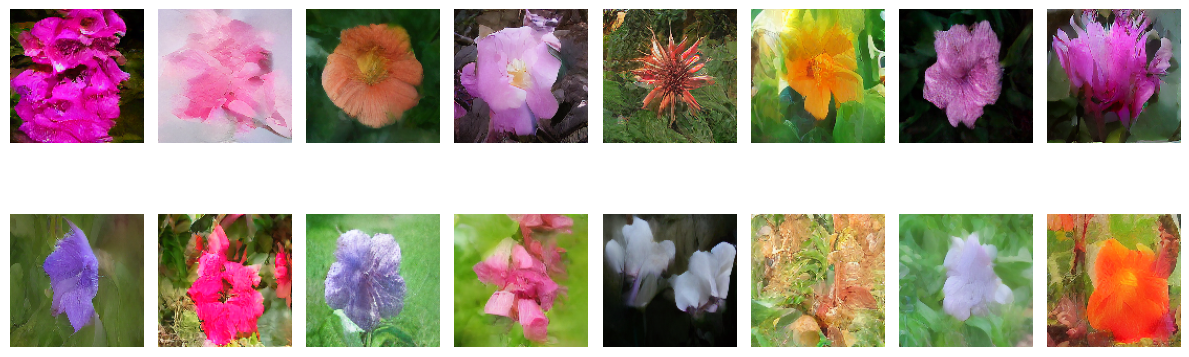

230/230 - 127s - n_loss: 0.0967 - i_loss: 0.1999 - val_n_loss: 0.0770 - val_i_loss: 0.1564 - val_kid: 0.7801 - 127s/epoch - 550ms/step
Epoch 3/50

Epoch 3: val_kid = 0.7284


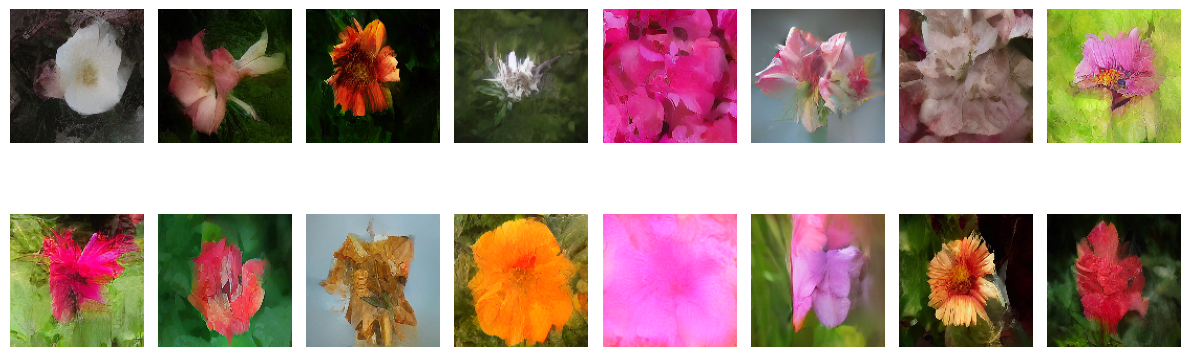

230/230 - 127s - n_loss: 0.0970 - i_loss: 0.2024 - val_n_loss: 0.0835 - val_i_loss: 0.1502 - val_kid: 0.7284 - 127s/epoch - 554ms/step
Epoch 4/50


In [ ]:
if __name__ == "__main__":
    # Prevent memory fragmentation
    os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
    
    BATCH_SIZE = 32
    TOTAL_EPOCHS = 50
    # Run the main pipeline
    run_diffusion_training(BATCH_SIZE, TOTAL_EPOCHS, continue_training=True)
